In [1]:
import numpy as np              # Python's standard numerical library
import matplotlib.pyplot as plt # Python's scientific visualization library
import pyidi                    # Python HSC data analysis library
import pickle as pk
import os
from pixel_setter2 import PixelSetter#, play_video, detect_peaks
from pixel_setter import play_video
from skimage import feature, measure
import importlib
from EMA_functions import *
import matplotlib.animation as animation
# from scipy.signal import convolve2d
from scipy.ndimage import generic_filter
root_drive_sim = os.path.normpath('G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Research Projects/Spiders/Simulations')
from moviepy.editor import VideoFileClip
from Feature_selecter import *

c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Import video

In [4]:
file_name = '30599_1_702.mov'
root_video = 'E:/Test1'
video_path = os.path.join(root_video, file_name)
clip = VideoFileClip(video_path)
# clip.fps = 4000
Total_Frame =40000
frames = []
for i, frame in enumerate(clip.iter_frames()):
    # if i%2 == 0:
        # continue
    if i >= Total_Frame:
        break
    frames.append(frame[:, :, 0])
frames = np.array(frames)
print(frames.shape)
video = pyidi.pyIDI(frames)
# video = EMA_structure.open_video()
del frames
del clip

(40000, 128, 1280)


In [8]:
EMA_structure = EMA_Structure(file_name)
video.info['Record Rate(fps)'] = 4000
video.info['Total Frame'] = Total_Frame
video.info['Image Width'] = 1024
video.info['Image Height'] = 512
video.info['File Format'] = 'mov'
video.info['EffectiveBit Depth'] = 8
video.info['Shutter Speed(s)'] = 0


video.root = root_video
EMA_structure.fs_camera = video.info['Record Rate(fps)']
EMA_structure.t_camera_raw = np.arange(video.info['Total Frame']) / EMA_structure.fs_camera
video.info

{'Record Rate(fps)': 4000,
 'Total Frame': 40000,
 'Image Width': 1024,
 'Image Height': 512,
 'File Format': 'mov',
 'EffectiveBit Depth': 8,
 'Shutter Speed(s)': 0}

### Plot still frame in video

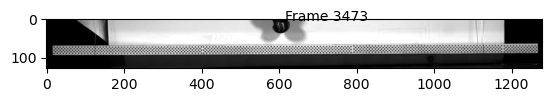

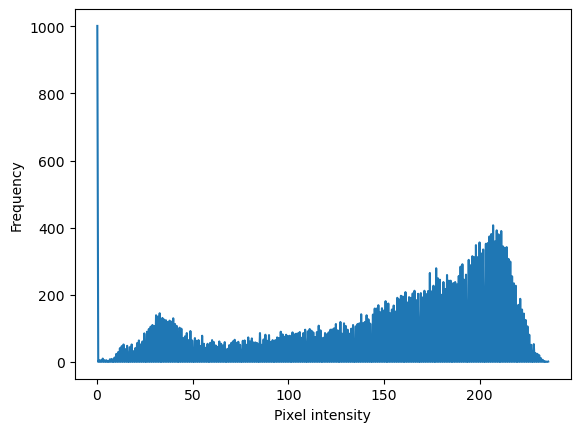

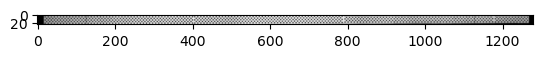

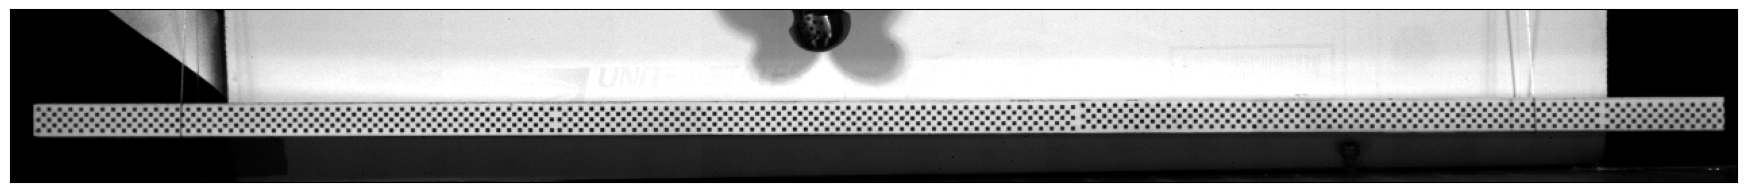

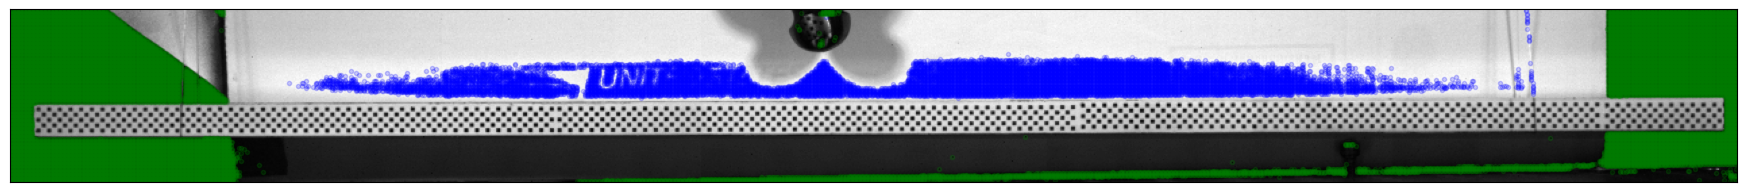

In [9]:
%matplotlib inline
sequential_image_n = 0
still_image = video.mraw[sequential_image_n]

fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation=False, bit_depth = 8)
fig.savefig(os.path.join(root_drive_sim, 'still images', f'{file_name}_frame_sat0.png'), dpi=300, bbox_inches='tight')
# plt.close(fig)

fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation=True, bit_depth = 8)
fig.savefig(os.path.join(root_drive_sim, 'still images','with saturation', f'{file_name}_frame_sat1.png'), dpi=300, bbox_inches='tight')
# plt.close(fig)

In [10]:
%matplotlib qt
first_frame = 1800
ani = play_video(video, range(first_frame,video.N - 1), interval=30)
hist_image = still_image[67:92,:]
get_PI_histogram(hist_image,bins=500, save_path=os.path.join(root_drive_sim, 'histograms'), save_name=f'{file_name}_histogram.png')
fig, ax = plt.subplots()
ax.imshow(hist_image, cmap='gray')
video.N

40000

In [11]:
%matplotlib qt
roi_size = (5,5)
reference_image = (0, 150)
n_tracking_points = 1200
mean_image      = np.mean(video.mraw[reference_image[0]:reference_image[1]], axis=0)
feature_selecter = FeatureSelecter(still_image)
feature_selecter.set_filter_method('eig0', roi_size)
# feature_selecter.plot_image()
score_full = feature_selecter.apply_filter(downsample=1)
maxima2d = feature_selecter.pick_max_filter(score_image = None, min_distance = roi_size[0], absolute_treshold = None, threshold_percentage = 20, top_n_points = n_tracking_points)
points = maxima2d[np.where((maxima2d[:,0]<93) & (maxima2d[:,0]>64))]
# maxima = feature_selecter.pick_ANMS(n_points = n_tracking_points, c_robust = 0.3)
feature_selecter.plot_score_image(maxima=True)
# eig_img = pix_set.find_eigenvalue_image(mean_image, roi_size[0], method = 'on_gradient')
# fig, ax = plt.subplots()
# plt.imshow(eig_img, cmap='gray')

Available filter methods: eig0, eig1, harris, trigs, harmonic_mean, eig_theta, eig_theta_off, eig0_test, eig1_test


(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [ ]:
video.set_method('lk')
video.method.configure(roi_size = roi_size, reference_image = reference_image, resume_analysis=False) #, mraw_range=(1, 1000)
points_lim = points[100:105]
video.set_points(points)
video.show_points()

In [ ]:
displacement = video.get_displacements(processes = 8)

In [ ]:
td     = video.displacements +  points_lim.reshape(len(points_lim),1,2)
ani = play_video(video, range(1800, video.N-1,10), interval=30, points=td[:, 1:, :])

In [ ]:
t_vec = np.arange(0, len(displacement[0, :, 0]), 1) /video.info['Record Rate(fps)']
fig, ax = plt.subplots(figsize=(12, 6))
for point in range(len(points_lim)):
    ax.plot(t_vec, displacement[point, :, 0], label=f'point {point}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Displacement (px)')
ax.legend()

In [ ]:
n_d = len(displacement[0, :, 0])
freq = np.fft.rfftfreq(n_d, 1/video.info['Record Rate(fps)'])
displacement_fft = np.fft.rfft(displacement, axis=1)
displacement_fft = np.abs(displacement_fft)
fig, ax = plt.subplots(figsize=(12, 6))
for point in range(len(points_lim)):
    ax.semilogy(freq, displacement_fft[point, :, 0], label=f'point {point}')
ax.set_xlim(0, 300)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
